#Tuning and Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import Sequential
#Values to be tuned
BATCH_SIZE = 32
initial_epochs = 14
fine_tune_epochs = 14
base_learning_rate = 0.005
optimizers = [tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10), 
              tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10)]
OPTIMIZER = optimizers[0]
LAYERS = 0
#Each extra layer this gets halved, ie 512 neurons, 256 neurons, etc
STARTING_NUM_NEURONS = 512

#Rest of Program

In [ ]:
#trolukovich/food11-image-dataset
_URL = 'https://storage.googleapis.com/foodclassdata/archive%20(1).zip'
path_to_zip = tf.keras.utils.get_file('archive%20(1).zip', origin=_URL, extract=True)
PATH = '/root/.keras/datasets/'
train_dir = os.path.join(PATH, 'training')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'evaluation')

1163229310/1163229310 [==============================] - 4s 0us/step


In [ ]:
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
class_names = train_dataset.class_names

Found 9866 files belonging to 11 classes.
Found 3430 files belonging to 11 classes.
Found 3347 files belonging to 11 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(11)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 11)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
the_model = tf.keras.Model(inputs, outputs)
model = Sequential()
model.add(the_model)
for i in range(LAYERS):
  model.add(tf.keras.layers.Dense(units = STARTING_NUM_NEURONS/(i+1)))
model.add(tf.keras.layers.Dense(11))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/14
309/309 [==============================] - 14s 37ms/step - loss: 1.0598 - accuracy: 0.6769 - val_loss: 0.7191 - val_accuracy: 0.7621
Epoch 2/14
309/309 [==============================] - 11s 34ms/step - loss: 0.7049 - accuracy: 0.7747 - val_loss: 0.7937 - val_accuracy: 0.7484
Epoch 3/14
309/309 [==============================] - 11s 34ms/step - loss: 0.6286 - accuracy: 0.7941 - val_loss: 0.7524 - val_accuracy: 0.7732
Epoch 4/14
309/309 [==============================] - 11s 34ms/step - loss: 0.6026 - accuracy: 0.8040 - val_loss: 0.6230 - val_accuracy: 0.7985
Epoch 5/14
309/309 [==============================] - 11s 34ms/step - loss: 0.5220 - accuracy: 0.8272 - val_loss: 0.5827 - val_accuracy: 0.8181
Epoch 6/14
309/309 [==============================] - 11s 34ms/step - loss: 0.5566 - accuracy: 0.8236 - val_loss: 1.4912 - val_accuracy: 0.6845
Epoch 7/14
309/309 [==============================] - 11s 34ms/step - loss: 0.8558 - accuracy: 0.7799 - val_loss: 0.6915 - val_accuracy:

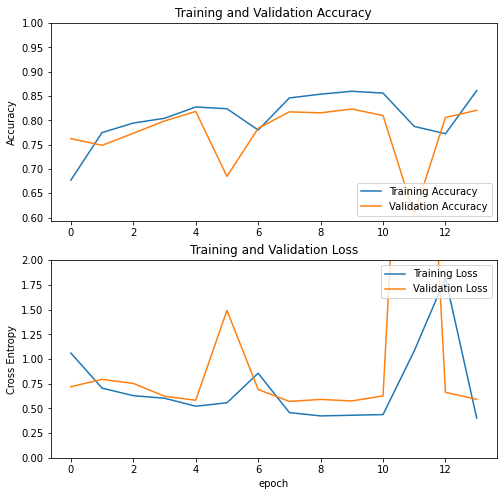

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = OPTIMIZER,
              metrics=['accuracy'])

total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 14/28
309/309 [==============================] - 16s 40ms/step - loss: 0.5100 - accuracy: 0.8291 - val_loss: 0.5878 - val_accuracy: 0.8163
Epoch 15/28
309/309 [==============================] - 11s 37ms/step - loss: 0.4011 - accuracy: 0.8633 - val_loss: 0.5634 - val_accuracy: 0.8239
Epoch 16/28
309/309 [==============================] - 11s 37ms/step - loss: 0.3457 - accuracy: 0.8824 - val_loss: 0.6221 - val_accuracy: 0.8082
Epoch 17/28
309/309 [==============================] - 12s 37ms/step - loss: 0.3007 - accuracy: 0.8972 - val_loss: 0.5195 - val_accuracy: 0.8385
Epoch 18/28
309/309 [==============================] - 12s 37ms/step - loss: 0.2744 - accuracy: 0.9065 - val_loss: 0.5149 - val_accuracy: 0.8504
Epoch 19/28
309/309 [==============================] - 12s 37ms/step - loss: 0.2420 - accuracy: 0.9168 - val_loss: 0.4726 - val_accuracy: 0.8598
Epoch 20/28
309/309 [==============================] - 12s 37ms/step - loss: 0.2164 - accuracy: 0.9250 - val_loss: 0.4745 - val_ac

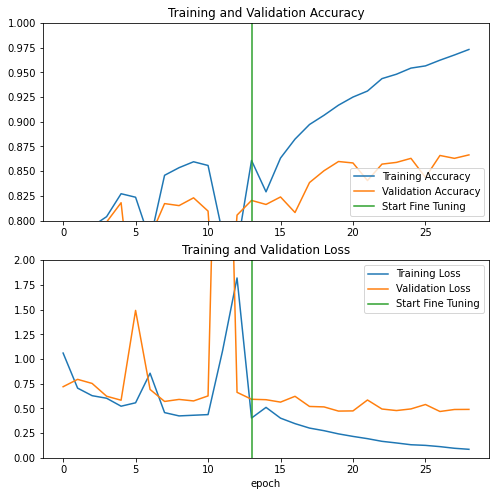

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
print('Test loss : ', loss)

105/105 [==============================] - 3s 27ms/step - loss: 0.3926 - accuracy: 0.8906
Test accuracy : 0.890648365020752
Test loss :  0.3926381468772888


Predictions:
 [ 3.3989336   1.5192938   3.583242   -1.6489005   4.014719   -0.12103435
 -8.180255   -8.266179   10.512104   -1.9091917  -0.4930445 ]
Labels:
 [ 8  4  9  5  0  2  3  9  9  3  5  8  3  8  1  2  2  1  9  3  1  8  5  2
  4  2  1  2  3 10  2  3]


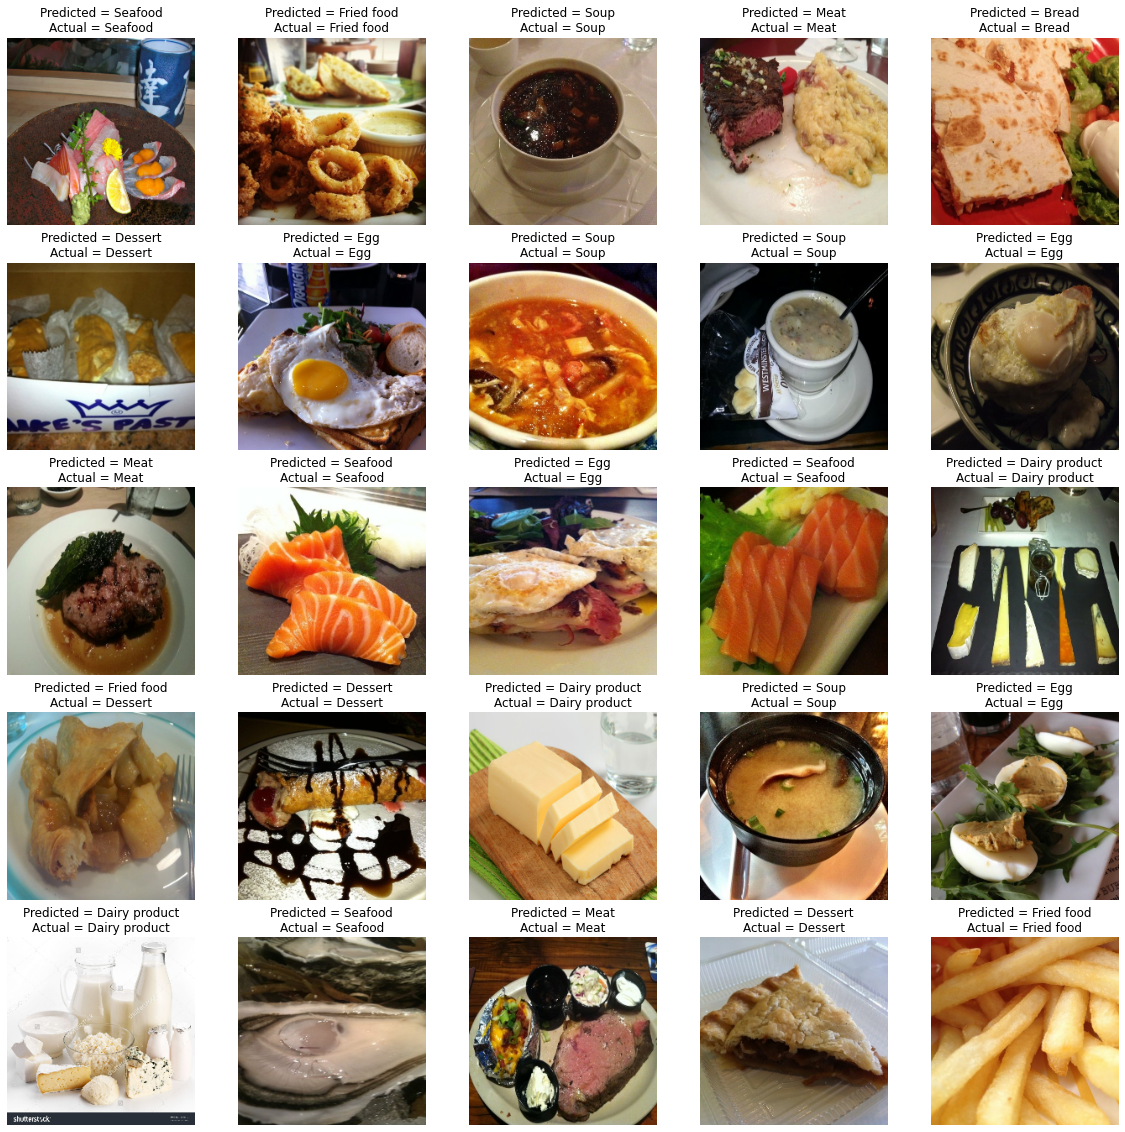

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

print('Predictions:\n', predictions[0])
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 20))
for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('Predicted = ' + class_names[np.argmax(predictions[i])] + '\nActual = ' + class_names[label_batch[i]])
  plt.axis("off")